# Tensorflow Object Detection Inference


In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

  Using cached https://files.pythonhosted.org/packages/4c/1a/0d79814736cfecc825ab8094b39648cc9c46af7af1bae839928acb73b4dd/tensorflow-2.2.0-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a4/f5/926ae53d6a226ec0fda5208e0e581cffed895ccc89e36ba76a8e60895b78/tensorflow_estimator-2.2.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1d/74/0a6fcb206dcc72a6da9a62dd81784bfdbff5fedb099982861dc2219014fb/tensorboard-2.2.2-py3-none-any.whl
ERROR: tf-models-official 2.4.0 has requirement tensorflow>=2.4.0, but you'll have tensorflow 2.2.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.

## Install Object Detection API

In [ ]:
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Using cached https://files.pythonhosted.org/packages/70/dc/e8c5e7983866fa4ef3fd619faa35f660b95b01a2ab62b3884f038ccab542/tensorflow-2.4.1-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/74/7e/622d9849abf3afb81e482ffc170758742e392ee129ce1540611199a59237/tensorflow_estimator-2.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/64/21/eebd23060763fedeefb78bc2b286e00fa1d8abda6f70efa2ee08c28af0d4/tensorboard-2.4.1-py3-none-any.whl
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1624271 sha256=fd10cdd7ef5f12d98b1665d23b89ab749ec5ce8624276715500c3e134a062853
  Stored in directory: /tmp/pip-ephem-wheel-cache-qdh00sd7/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-

## Imports and setup

In [ ]:
import os
import io
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import time

import tensorflow as tf

from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

## Connect with drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load model

In [ ]:
ROOT = 'gdrive/MyDrive/MIA2/landmark_detections'
PATH_TO_SAVED_MODEL = os.path.join(ROOT, 'models', 'saved_model')
PATH_TO_LABELS = os.path.join(ROOT, 'landmarks_label_map.pbtxt')

print('Model path {}'.format(PATH_TO_SAVED_MODEL))
print('Label path {}'.format(PATH_TO_LABELS))

Model path gdrive/MyDrive/MIA2/landmark_detections/models/saved_model
Label path gdrive/MyDrive/MIA2/landmark_detections/landmarks_label_map.pbtxt


In [ ]:
# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Model loaded')

Model loaded


## Load label map

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'mark'}}

## Run detections

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  return np.array(Image.open(path))

In [ ]:
IMAGES_FOLDER = os.path.join(ROOT, 'data')
images_list = os.listdir(IMAGES_FOLDER)
print('Images folder {}'.format(IMAGES_FOLDER))

Images folder gdrive/MyDrive/MIA2/landmark_detections/data


1/14. Running inference for img_150.jpg


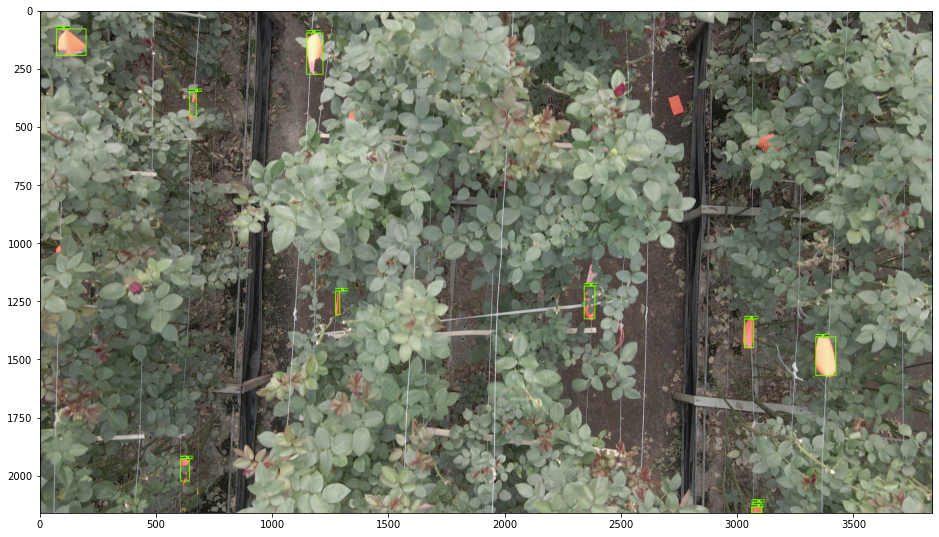

In [ ]:
for idx, image_name in enumerate(images_list):
  print('{}/{}. Running inference for {}'.format(idx + 1, len(images_list), image_name))
  image_np = load_image_into_numpy_array(os.path.join(IMAGES_FOLDER, image_name))
  input_tensor = tf.convert_to_tensor(image_np)
  input_tensor = input_tensor[tf.newaxis, ...]

  # run detections
  detections = detect_fn(input_tensor)

  num_detections = int(detections.pop('num_detections'))

  detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
  detections['num_detections'] = num_detections
  
  # detection_classes should be ints
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  image_np_with_detections = image_np.copy()
  label_id_offset = 1
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=20,
      min_score_thresh=.50,
      agnostic_mode=False)
  plt.figure(figsize=(16, 20))
  plt.imshow(image_np_with_detections)
  # analyze only one image
  break
plt.show()

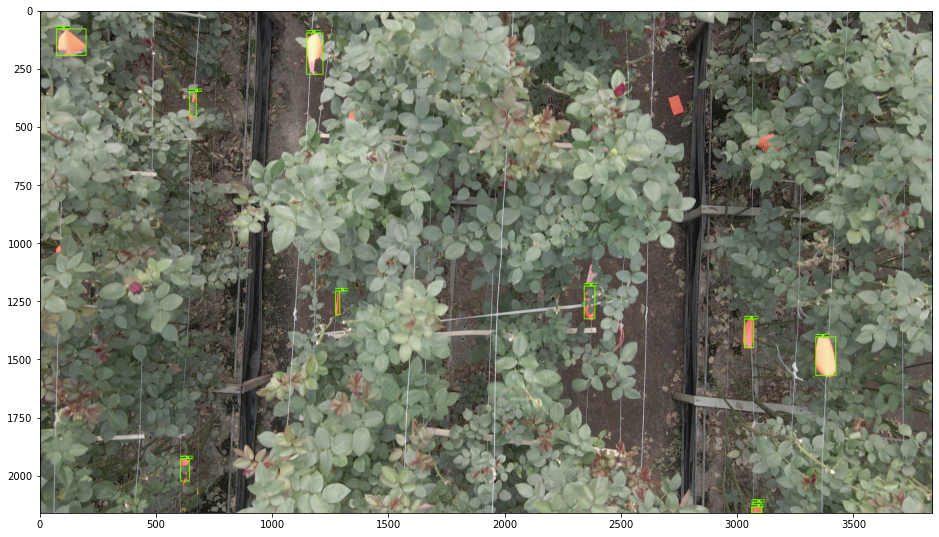

In [185]:
image_name = 'img_150.jpg'
image_np = load_image_into_numpy_array(os.path.join(IMAGES_FOLDER, image_name))
input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

# run detections
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))

detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()
label_id_offset = 1
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'],
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=20,
    min_score_thresh=.50,
    agnostic_mode=False)
plt.figure(figsize=(16, 20))
plt.imshow(image_np_with_detections)
plt.show()

## Analyze 'Y' distance

In [186]:
def euclidian_distance(p1, p2):
  return round(((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)**0.5, 1)

def y_distance(p1, p2):
  return abs(p2[1] - p1[1])

def get_centroid(coords):
  ymin, xmin, ymax, xmax = coords
  x_ = (xmin + xmax) / 2
  y_ = (ymin + ymax) / 2
  return (x_, y_)

In [187]:
min_score_thresh = .5
h, w, _ = image_np.shape
y_ = []

for idx, score in enumerate(detections['detection_scores']):
  if score >= min_score_thresh:
    ymin, xmin, ymax, xmax = detections['detection_boxes'][idx]
    ymin, xmin, ymax, xmax = int(ymin * h), int(xmin * w), int(ymax * h), int(xmax * w)
    y_.append((ymin + ymax) / 2)

In [188]:
len(y_)

10

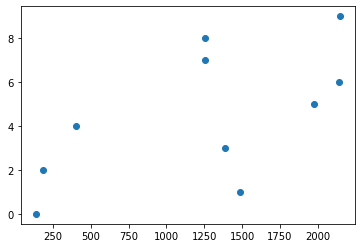

In [189]:
plt.scatter(y_, range(len(y_)))

## Clustering

In [190]:
from sklearn.cluster import KMeans

In [191]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(np.array(y_).reshape(-1, 1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [192]:
print(kmeans.labels_)

cnt_dict = {}

counter = np.unique(kmeans.labels_, return_counts=True)
for key, ctr in zip(counter[0], counter[1]):
  cnt_dict[key] = ctr
print(cnt_dict)

[1 0 1 0 1 2 2 0 0 2]
{0: 4, 1: 3, 2: 3}


In [193]:
groups = {}
for d, cluster in zip(y_, kmeans.labels_):
  groups[cluster] = groups.get(cluster, 0) + d

for key in groups.keys():
  groups[key] /= cnt_dict[key]

print(groups)

{1: 242.5, 0: 1346.625, 2: 2086.0}


In [194]:
lines = []
for key in cnt_dict.keys():
  if cnt_dict[key] > 1:
    lines.append(int(groups[key]))
print(lines)

[1346, 242, 2086]


## Draw lines

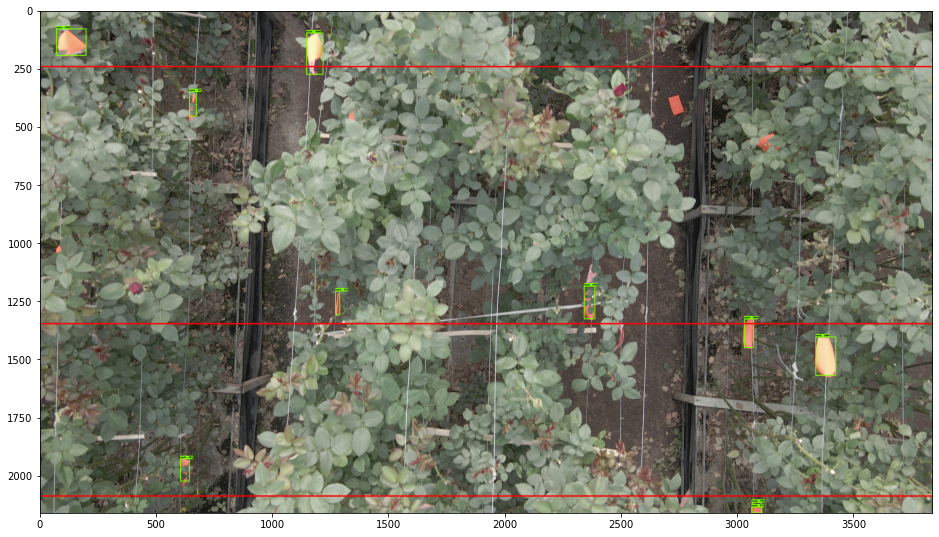

In [199]:
img = Image.fromarray(image_np_with_detections.copy(), 'RGB')
draw = ImageDraw.Draw(img)

for limit in lines:
  draw.line([(0, limit), (w, limit)], width=6, fill='red')
plt.figure(figsize=(16, 20))
plt.imshow(img)
plt.show()